### Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from DataPreparation import *
from Model import *
from BootstrapFeatureImportance import *
from helper_functions import *

# **1. Loading Data**

In [3]:
# import the preprocessed data as pandas dataframe
sif_dataset = pd.read_csv("../Data/preprocessed_data/exp0_df_bs_v2.csv", index_col="Unnamed: 0")
sif_X = sif_dataset.drop("YPSII", axis=1)

## 1.1 Prepare data for modelling

In [4]:
# train-test split on whole dataset
data_prep = DataPreparation(sif_dataset, "YPSII")
y_digitised = data_prep.digitize_column("YPSII")
train, test = data_prep.train_test_split(0.20, 5, stratify=y_digitised)

In [5]:
# preparing train data for splitting in k folds
data_prep_train = DataPreparation(train, "YPSII")
train_y_bins = data_prep_train.digitize_column("YPSII")
train_X = train.drop("YPSII",axis=1)
train_y = train[["YPSII"]]

# **2. Implement Random Forest (RF) model**

In [6]:
# define parameter grid for grid-search cross validation

param_grid_rf = {"n_estimators":[100, 200, 300, 500, 1000],
                 "max_depth":[10, 20, 50, 100, 200],
                 "min_samples_leaf":[1, 5, 10, 20],
                }

# define scoring metrics for grid-search cv
scoring_metrics = ['neg_mean_squared_error','neg_mean_absolute_error','r2']

# define k-fold object
k_fold_iter = k_folds(5, 5)

# use following code when tuning model from scratch
"""
# model tuning
rf = Model(sklearn.ensemble.RandomForestRegressor(), train, "YPSII")
all_models_rf, best_model_rf = rf.tuned_model(k_fold_iter.split(train_X, train_y_bins),
                                              param_grid_rf, scoring_metrics, "neg_mean_squared_error")

# saving the data of all the candidates model (possible combination of hyperparameters)
model_df_rf = pd.DataFrame(all_models_rf.cv_results_)
model_df_rf.to_csv("RF_models_full.csv", index=False)

# saving tuned model using joblib
rf.save_model("RF_tuned_model")
"""

# load previously tuned model
best_model_rf = joblib.load("../Model files/RF_tuned_model")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


## 2.1 RF model optimization analysis


In [7]:
# load the data of model tuning from grid-search cross-validation 
rf_tuning_data = pd.read_csv("../Model files/RF_models_full.csv")
rf_tuning_data["MSE_test"] = rf_tuning_data["mean_test_neg_mean_squared_error"]*-1

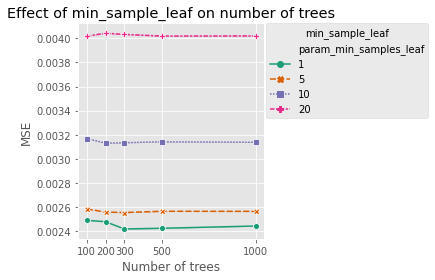

In [8]:
# plot effect of 'minimum sample leaf' parameter on MSE for given 'number of trees'
plt.style.use("ggplot")
plt.grid(True)
sns.lineplot(data=rf_tuning_data, x="param_n_estimators", y="MSE_test", 
             hue="param_min_samples_leaf", ci=False, estimator="mean", 
             palette="Dark2", style="param_min_samples_leaf", markers=True)

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, title="min_sample_leaf")
plt.xlabel("Number of trees")
plt.ylabel("MSE")
plt.title("Effect of min_sample_leaf on number of trees")
plt.xticks(ticks=[100,200,300,500,1000])
plt.tight_layout()
plt.savefig("RF optimization trees with leaf.png", dpi=500)
plt.show()

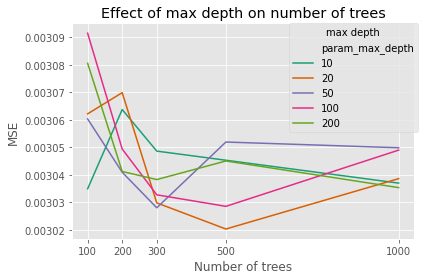

In [11]:
# plot effect of 'max depth' parameter on MSE for given 'number of trees'
plt.style.use("ggplot")
plt.grid(True)
sns.lineplot(data=rf_tuning_data, x="param_n_estimators", y="MSE_test", 
             hue="param_max_depth", ci=None, estimator="mean", palette="Dark2")

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, title="max depth")
plt.xlabel("Number of trees")
plt.ylabel("MSE")
plt.title("Effect of max depth on number of trees")
plt.xticks(ticks=[100,200,300,500,1000])
plt.tight_layout()
plt.savefig("RF optimization trees with depth.png", dpi=500)
plt.show()

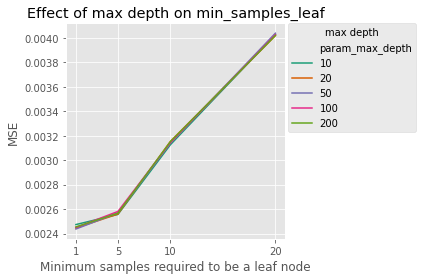

In [12]:
# plot effect of parameter 'max depth' on MSE for given values of paramter 'minimum sample leaf' 
plt.style.use("ggplot")
plt.grid(True)
sns.lineplot(data=rf_tuning_data, x="param_min_samples_leaf", y="MSE_test", 
             hue="param_max_depth", ci=None, estimator="mean", palette="Dark2")
             
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0, title="max depth")
plt.xlabel("Minimum samples required to be a leaf node")
plt.ylabel("MSE")
plt.title("Effect of max depth on min_samples_leaf")
plt.xticks(ticks=[1,5,10,20])
plt.tight_layout()
plt.savefig("RF optimization leaf with depth.png", dpi=500)
plt.show()

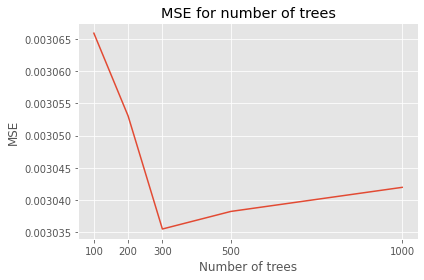

In [13]:
# plot effect of parameter 'number of trees' on MSE
plt.style.use("ggplot")
plt.grid(True)
sns.lineplot(data=rf_tuning_data,  y="MSE_test", x="param_n_estimators",
             ci=None, estimator="mean", palette="Dark2", markers=True)
             
plt.xlabel("Number of trees")
plt.ylabel("MSE")
plt.title("MSE for number of trees")
plt.xticks(ticks=[100,200,300,500,1000])
plt.tight_layout()
plt.savefig("MSE for number of trees.png", dpi=500)
plt.show()

## 2.2 Identify feature importance from the model (without bootstrapping)

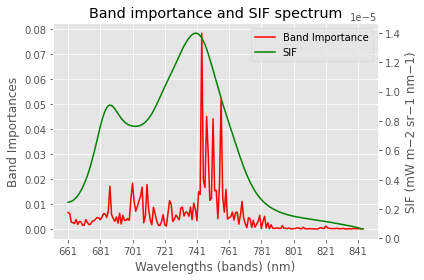

In [14]:
# plotting feature importance and SIF spectrum
fig, ax1 = plt.subplots()

ax1.set_xlabel('Wavelengths (bands) (nm)')
ax1.set_ylabel('Band Importances')
l1 = ax1.plot(train_X.columns,best_model_rf.feature_importances_,color="red", label='Band Importance')
ax1.tick_params(axis='y')
ax1.set_xticks(train_X.columns[::20])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('SIF (mW m−2 sr−1 nm−1)')  
l2 = ax2.plot(sif_X.mean(axis=0), color="green", label="SIF")
ax2.tick_params(axis='y')
ax2.set_xticks(train_X.columns[::20])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
plt.grid()
plt.title("Band importance and SIF spectrum")
plt.tight_layout()
plt.savefig("RF_without_bootstrapped.png", dpi = 1000)

plt.show()

## 2.3 Identify feature importance from the model using bootstrapping

In [15]:
# caculate bootstrapped feature importance
boostrap_obj = BootstrapFeatureImportance(train, "YPSII")
band_imp_dict = boostrap_obj.bootstrapped_feature_importance(best_model_rf,93,500)

Bootstrapping 1 .....
Bootstrapping 2 .....
Bootstrapping 3 .....
Bootstrapping 4 .....
Bootstrapping 5 .....
Bootstrapping 6 .....
Bootstrapping 7 .....
Bootstrapping 8 .....
Bootstrapping 9 .....
Bootstrapping 10 .....
Bootstrapping 11 .....
Bootstrapping 12 .....
Bootstrapping 13 .....
Bootstrapping 14 .....
Bootstrapping 15 .....
Bootstrapping 16 .....
Bootstrapping 17 .....
Bootstrapping 18 .....
Bootstrapping 19 .....
Bootstrapping 20 .....
Bootstrapping 21 .....
Bootstrapping 22 .....
Bootstrapping 23 .....
Bootstrapping 24 .....
Bootstrapping 25 .....
Bootstrapping 26 .....
Bootstrapping 27 .....
Bootstrapping 28 .....
Bootstrapping 29 .....
Bootstrapping 30 .....
Bootstrapping 31 .....
Bootstrapping 32 .....
Bootstrapping 33 .....
Bootstrapping 34 .....
Bootstrapping 35 .....
Bootstrapping 36 .....
Bootstrapping 37 .....
Bootstrapping 38 .....
Bootstrapping 39 .....
Bootstrapping 40 .....
Bootstrapping 41 .....
Bootstrapping 42 .....
Bootstrapping 43 .....
Bootstrapping 44 ...

Bootstrapping 347 .....
Bootstrapping 348 .....
Bootstrapping 349 .....
Bootstrapping 350 .....
Bootstrapping 351 .....
Bootstrapping 352 .....
Bootstrapping 353 .....
Bootstrapping 354 .....
Bootstrapping 355 .....
Bootstrapping 356 .....
Bootstrapping 357 .....
Bootstrapping 358 .....
Bootstrapping 359 .....
Bootstrapping 360 .....
Bootstrapping 361 .....
Bootstrapping 362 .....
Bootstrapping 363 .....
Bootstrapping 364 .....
Bootstrapping 365 .....
Bootstrapping 366 .....
Bootstrapping 367 .....
Bootstrapping 368 .....
Bootstrapping 369 .....
Bootstrapping 370 .....
Bootstrapping 371 .....
Bootstrapping 372 .....
Bootstrapping 373 .....
Bootstrapping 374 .....
Bootstrapping 375 .....
Bootstrapping 376 .....
Bootstrapping 377 .....
Bootstrapping 378 .....
Bootstrapping 379 .....
Bootstrapping 380 .....
Bootstrapping 381 .....
Bootstrapping 382 .....
Bootstrapping 383 .....
Bootstrapping 384 .....
Bootstrapping 385 .....
Bootstrapping 386 .....
Bootstrapping 387 .....
Bootstrapping 38

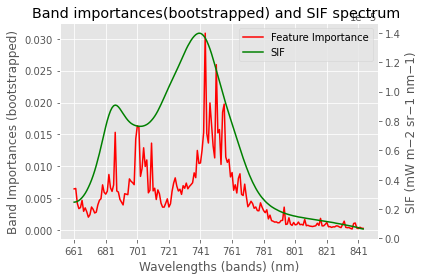

In [16]:
# plotting bootstrapped feature importance and SIF spectrum
fig, ax1 = plt.subplots()
    
ax1.set_xlabel('Wavelengths (bands) (nm)')
ax1.set_ylabel('Band Importances (bootstrapped)')
l1 = ax1.plot(train_X.columns,list(band_imp_dict.values()),color="red", label='Feature Importance')
ax1.tick_params(axis='y')
ax1.set_xticks(train_X.columns[::20])

ax2 = ax1.twinx()  
ax2.set_ylabel('SIF (mW m−2 sr−1 nm−1)')  
l2 = ax2.plot(sif_X.mean(axis=0), color="green", label="SIF")
ax2.tick_params(axis='y')
ax2.set_xticks(train_X.columns[::20])

lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
plt.grid()

plt.tight_layout()
plt.title("Band importances(bootstrapped) and SIF spectrum ")
fig.tight_layout()  

plt.savefig("RF_with_bootstrapped.png", dpi = 1000)

plt.show()

## 2.4 Prediction Interval

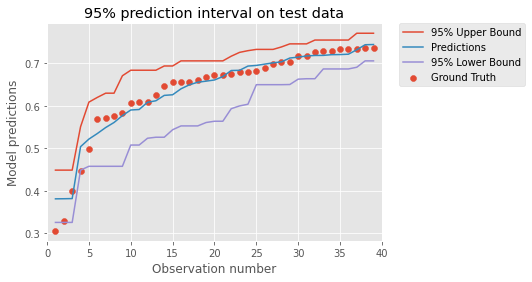

In [17]:
percentile = 95
err_down, err_up = pred_ints(best_model_rf, test.iloc[:,:-1], percentile)
test_y_pred = best_model_rf.predict(test.iloc[:,:-1])
test_y_true = test.iloc[:,-1]

# plot 95% prediction interval about the model predictions
plt.style.use("ggplot")
plt.plot(range(1,len(np.sort(test_y_true)) + 1),np.sort(err_up), label="95% Upper Bound")
plt.plot(range(1,len(np.sort(test_y_true)) + 1),np.sort(test_y_pred), label="Predictions")
plt.plot(range(1,len(np.sort(test_y_true)) + 1),np.sort(err_down), label="95% Lower Bound")
plt.scatter(range(1,len(np.sort(test_y_true)) + 1),np.sort(test_y_true), label="Ground Truth")
plt.xlabel("Observation number")
plt.ylabel("Model predictions")
plt.xlim(0, 40)
plt.legend()
plt.title(f"{percentile}% prediction interval on test data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, c='white')
plt.savefig(f"{percentile}% prediction interval on test data", dpi=1000, bbox_inches='tight')

plt.show()

In [19]:
# checking proportion of true values that fall within 95% prediction error
np.mean(np.logical_and(np.sort(err_down) < np.sort(test.iloc[:,-1]), np.sort(err_up) > np.sort(test.iloc[:,-1])))

0.9487179487179487

## 2.5 Recursive Feature Elimination

In [20]:
# create empty objects for mse, mae and r2 score
n_features_mse = {}
n_features_r2 = {}
n_features_mae = {}
rfe_cv_objects = {}
num_features = list(range(5, 184, 5)) + [184]


### execute following code when 'n_features_metrics.pkl' file is not available
# for n in num_features:
#     for i in range(1, 11):
#         rfe = RFE(rf_best_model, n, 0.25)
#         rfe_cv = cross_validate(rfe, train_X, train_y.values.ravel(), scoring=scoring_metrics, cv=k_fold_iter.split(train_X, train_y_bins), n_jobs=-1)
#         rfe_cv_objects[i, n] = rfe_cv
#         n_features_mse[i, n] = -1*np.mean(rfe_cv["test_neg_mean_squared_error"])
#         n_features_mae[i, n] = -1*np.mean(rfe_cv["test_neg_mean_absolute_error"])
#         n_features_r2[i, n] = np.mean(rfe_cv["test_r2"])

In [22]:
# store the objects
# with open('n_features_metrics_3.pkl', 'wb') as f:  
#  pickle.dump([n_features_mse, n_features_mae, n_features_r2], f)

# with open('rfe_cv_objects.pkl', 'wb') as f:  
#  pickle.dump([rfe_cv_objects], f)


# load the saved objects
with open('../Model files/n_features_metrics.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    n_features_mse, n_features_mae, n_features_r2 = pickle.load(f)    

In [23]:
# calculate mse, mae and R2 for each combination of features
n_features_mean_mse = {}
n_features_mean_mae = {}
n_features_mean_r2 = {}

for n in num_features:
    n_features_mean_mse[n] = np.mean([n_features_mse[i, n] for i in range(1,11)])
    n_features_mean_mae[n] = np.mean([n_features_mae[i, n] for i in range(1,11)])
    n_features_mean_r2[n] = np.mean([n_features_r2[i, n] for i in range(1,11)])

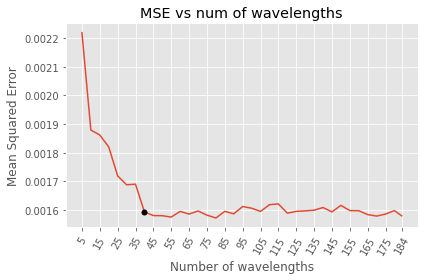

In [24]:
# plot MSE against various combination of bands (wavelengths) as features
plt.plot(list(n_features_mean_mse.keys()), list(n_features_mean_mse.values()))
plt.xticks(list(n_features_mean_mse.keys())[::2], rotation=60)
plt.xlabel("Number of wavelengths")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs num of wavelengths")
plt.plot(40, n_features_mean_mse[40], marker="o", markersize=5, color="black")
plt.tight_layout()
plt.savefig("MSE vs num of wavelenghts", dpi=1000)
plt.show()

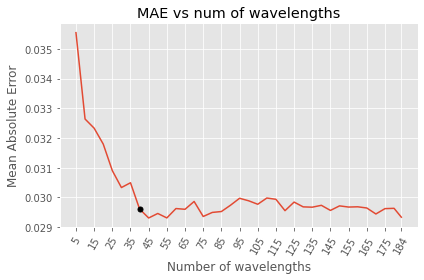

In [25]:
# plot MAE against various combination of bands (wavelengths) as features
plt.plot(list(n_features_mean_mae.keys()), list(n_features_mean_mae.values()))
plt.xticks(list(n_features_mean_mse.keys())[::2], rotation=60)
plt.xlabel("Number of wavelengths")
plt.ylabel("Mean Absolute Error")
plt.title("MAE vs num of wavelengths")
plt.plot(40, n_features_mean_mae[40], marker="o", markersize=5, color="black")
plt.tight_layout()
plt.savefig("MAE vs num of wavelengths", dpi=1000)
plt.show()

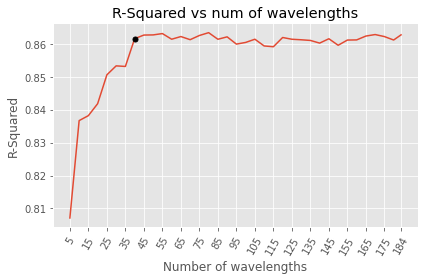

In [26]:
# plot MAE against various combination of bands (wavelengths) as features
plt.plot(list(n_features_mean_r2.keys()), list(n_features_mean_r2.values()))
plt.xticks(list(n_features_mean_r2.keys())[::2], rotation=60)
plt.xlabel("Number of wavelengths")
plt.ylabel("R-Squared")
plt.title("R-Squared vs num of wavelengths")
plt.plot(40, n_features_mean_r2[40], marker="o", markersize=5, color="black")
plt.tight_layout()
plt.savefig("R-squared vs num of wavelengths", dpi=1000)
plt.show()

In [27]:
# Extracting top n important bands
num_important_bands = 40
rfe_important_features = RFE(best_model_rf, num_important_bands, 0.05)
rfe_important_features.fit(train_X, train_y.values.ravel())
important_bands = test.drop("YPSII", axis=1).columns[rfe_important_features.get_support()]
band_importances = rfe_important_features.estimator_.feature_importances_

important_bands_importance_value = dict(zip(important_bands, band_importances))

# full_bands_importance_value = {x:0 for x in test.drop("YPSII", axis=1).columns }
# for x in test.drop("YPSII", axis=1).columns:
#     if x in imp_bands:
#         full_bands_importance_value[x] = important_bands_importance_value.get(x)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=40, step=0.05 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


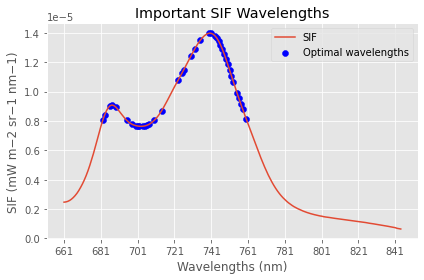

In [28]:
# plot important bands on SIF spectrum
plt.plot(sif_X.mean(axis=0), label="SIF")
plt.xticks(sif_X.columns[::20])
plt.scatter(important_bands, sif_X.mean(axis=0)[important_bands], marker='o', c="b", label="Optimal wavelengths")
plt.xlabel("Wavelengths (nm)")
plt.ylabel("SIF (mW m−2 sr−1 nm−1)")
plt.title("Important SIF Wavelengths")
plt.legend()
plt.tight_layout()
plt.savefig(f"{top_bands} Imp Wavelengths", dpi=1000)

plt.show()

## 2.6 Compare full bands against top n bands from RFE

In [29]:
# Full Bands
MAE_full = mean_absolute_error(test["YPSII"], best_model_rf.predict(test.drop("YPSII", axis=1))) 
MSE_full = mean_squared_error(test["YPSII"], best_model_rf.predict(test.drop("YPSII", axis=1))) 
R2_full = r2_score(test["YPSII"], best_model_rf.predict(test.drop("YPSII", axis=1))) 

# top n Bands
MAE_n = n_features_mean_mae[num_important_bands]
MSE_n = n_features_mean_mse[num_important_bands]
R2_n = n_features_mean_r2[num_important_bands]

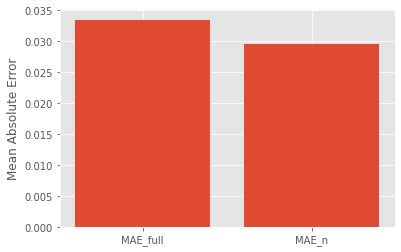

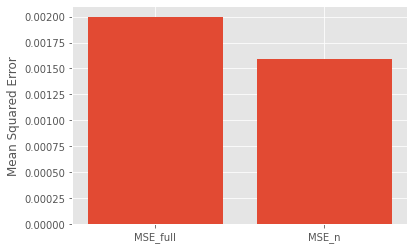

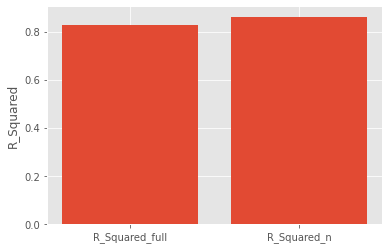

In [30]:
# plot the comparison results between full bands and top n bands
plt.figure()
plt.bar(["MAE_full", "MAE_n"], [MAE_full, MAE_n])
plt.ylabel("Mean Absolute Error")
plt.show()

plt.figure()
plt.bar(["MSE_full", "MSE_n"], [MSE_full, MSE_n])
plt.ylabel("Mean Squared Error")
plt.show()

plt.figure()
plt.bar(["R_Squared_full", "R_Squared_n"], [R2_full, R2_n])
plt.ylabel("R_Squared")
plt.show()

# 3. Comparison With Linear Regression

### 3.1 Univariate linear regression with individual band from full bands

In [31]:
# fit univariate linear regression model where each band is a predictor
test_X = test.drop("YPSII", axis=1)
linreg_single_band_mse = {}
linreg_single_band_mae = {}
linreg_single_band_r2 = {}

for x in train_X.columns:
    linreg_single_band = LinearRegression()
    linreg_single_band.fit(train_X[x].values.reshape(-1,1), train_y.values.reshape(-1,1))
    linreg_single_band_test_predictions = linreg_single_band.predict(test_X[x].values.reshape(-1,1))
    linreg_single_band_r2[x] = linreg_single_band.score(test_X[x].values.reshape(-1,1), test["YPSII"].values.reshape(-1,1))
    linreg_single_band_mse[x] = mean_squared_error(test["YPSII"].values.reshape(-1,1), linreg_single_band_test_predictions)
    linreg_single_band_mae[x] = mean_absolute_error(test["YPSII"].values.reshape(-1,1), linreg_single_band_test_predictions)

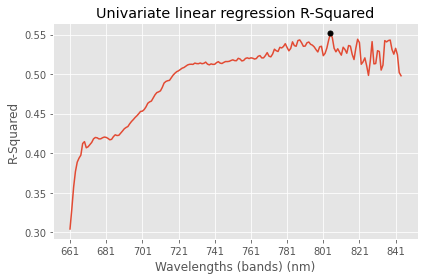

In [32]:
# plot the R-squared of the liner model for test predictions
plt.style.use("ggplot")
plt.plot(train_X.columns, list(linreg_single_band_r2.values()))
plt.xticks(train_X.columns[::20])
plt.grid(c="white")
plt.xlabel("Wavelengths (bands) (nm)")
plt.ylabel("R-Squared")
plt.plot(np.argmax(list(linreg_single_band_r2.values())), np.max(list(linreg_single_band_r2.values())), marker="o", markersize=5, color="black")
plt.title("Univariate linear regression R-Squared")
plt.tight_layout()
plt.grid(True)
plt.savefig("R2 Linear Regression (individual bands)", dpi=500)
plt.show()

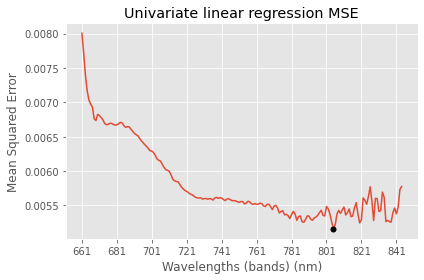

In [33]:
# plot the mean squared error of the liner model for test predictions
plt.plot(train_X.columns, list(linreg_single_band_mse.values()))
plt.xticks(train_X.columns[::20])
plt.grid(c="white")
plt.xlabel("Wavelengths (bands) (nm)")
plt.ylabel("Mean Squared Error")
plt.plot(np.argmin(list(linreg_single_band_mse.values())), np.min(list(linreg_single_band_mse.values())), marker="o", markersize=5, color="black")
plt.title("Univariate linear regression MSE")
plt.tight_layout()
plt.savefig("MSE Linear Regression (individual bands)", dpi=500)

plt.show()

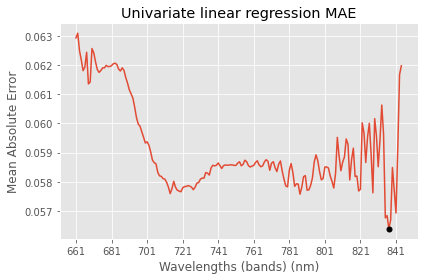

In [34]:
# plot the mean absolute error of the liner model for test predictions
plt.plot(train_X.columns, list(linreg_single_band_mae.values()))
plt.xticks(train_X.columns[::20])
plt.grid(c="white")
plt.xlabel("Wavelengths (bands) (nm)")
plt.ylabel("Mean Absolute Error")
plt.plot(np.argmin(list(linreg_single_band_mae.values())), np.min(list(linreg_single_band_mae.values())), marker="o", markersize=5, color="black")
plt.title("Univariate linear regression MAE")
plt.tight_layout()
plt.savefig("MAE Linear Regression (individual bands)", dpi=500)

plt.show()